In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [ ]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
lrv_train = np.array(Dataset_loader('/content/drive/MyDrive/potato1/train1/LeafRoll',224))
virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
lrv_test = np.array(Dataset_loader('/content/drive/MyDrive/potato1/test1/LeafRoll ',224))
virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 200/200 [00:11<00:00, 17.09it/s]


In [ ]:
print(len(lrv_test))

200


In [ ]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),2)
healthy_train_label = np.full(len(healthy_train),3)
insect_train_label = np.full(len(insect_train),4)
lrv_train_label = np.full(len(lrv_train),5)
virus_train_label = np.full(len(virus_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),2)
healthy_test_label = np.full(len(healthy_test),3)
insect_test_label = np.full(len(insect_test),4)
lrv_test_label = np.full(len(lrv_test),5)
virus_test_label = np.full(len(virus_test),6)

In [ ]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, early_blight_serious_train, late_blight_train, healthy_train, insect_train, lrv_train, virus_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, early_blight_serious_train_label, late_blight_train_label, healthy_train_label, insect_train_label, lrv_train_label, virus_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, early_blight_serious_test, late_blight_test, healthy_test, insect_test, lrv_test,  virus_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, early_blight_serious_test_label, late_blight_test_label, healthy_test_label, insect_test_label, lrv_test_label, virus_test_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 7)
Y_test = to_categorical(Y_test, num_classes= 7)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)


vgg16      = VGG16(include_top=False, input_shape=input_shape)(inputs)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(vgg16)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(7, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 concatenate_1 (Concatenate  (None, 512)               0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048

In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/Vgg16(7_classes).hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
137/136 [==============================] - ETA: 0s - loss: 1.7939 - accuracy: 0.3465

136/136 [==============================] - 128s 749ms/step - loss: 1.7939 - accuracy: 0.3465 - val_loss: 1.6136 - val_accuracy: 0.4922 - lr: 1.0000e-04
Epoch 2/50
137/136 [==============================] - ETA: 0s - loss: 1.0603 - accuracy: 0.5792

136/136 [==============================] - 84s 616ms/step - loss: 1.0603 - accuracy: 0.5792 - val_loss: 2.4385 - val_accuracy: 0.3797 - lr: 1.0000e-04
Epoch 3/50
137/136 [==============================] - ETA: 0s - loss: 0.7227 - accuracy: 0.6979

136/136 [==============================] - 85s 622ms/step - loss: 0.7227 - accuracy: 0.6979 - val_loss: 0.4496 - val_accuracy: 0.8033 - lr: 1.0000e-04
Epoch 4/50
137/136 [==============================] - ETA: 0s - loss: 0.5609 - accuracy: 0.7625

136/136 [==============================] - 89s 653ms/step - loss: 0.5609 - accuracy: 0.7625 - val_loss: 0.2120 - val_accuracy: 0.9296 - lr: 1.0000e-04
Epoch 5/50
137/136 [==============================] - ETA: 0s - loss: 0.4539 - accuracy: 0.8142

136/136 [==============================] - 85s 621ms/step - loss: 0.4539 - accuracy: 0.8142 - val_loss: 0.3262 - val_accuracy: 0.8683 - lr: 1.0000e-04
Epoch 6/50
137/136 [==============================] - ETA: 0s - loss: 0.4384 - accuracy: 0.8233

136/136 [==============================] - 85s 619ms/step - loss: 0.4384 - accuracy: 0.8233 - val_loss: 0.2012 - val_accuracy: 0.8902 - lr: 1.0000e-04
Epoch 7/50
137/136 [==============================] - ETA: 0s - loss: 0.4122 - accuracy: 0.8330

136/136 [==============================] - 83s 609ms/step - loss: 0.4122 - accuracy: 0.8330 - val_loss: 0.1570 - val_accuracy: 0.9497 - lr: 1.0000e-04
Epoch 8/50
137/136 [==============================] - ETA: 0s - loss: 0.3653 - accuracy: 0.8533

136/136 [==============================] - 84s 613ms/step - loss: 0.3653 - accuracy: 0.8533 - val_loss: 0.2098 - val_accuracy: 0.9323 - lr: 1.0000e-04
Epoch 9/50
137/136 [==============================] - ETA: 0s - loss: 0.3515 - accuracy: 0.8570

136/136 [==============================] - 85s 625ms/step - loss: 0.3515 - accuracy: 0.8570 - val_loss: 0.1319 - val_accuracy: 0.9607 - lr: 1.0000e-04
Epoch 10/50
137/136 [==============================] - ETA: 0s - loss: 0.3158 - accuracy: 0.8744

136/136 [==============================] - 85s 622ms/step - loss: 0.3158 - accuracy: 0.8744 - val_loss: 0.1784 - val_accuracy: 0.9424 - lr: 1.0000e-04
Epoch 11/50
137/136 [==============================] - ETA: 0s - loss: 0.3205 - accuracy: 0.8771

136/136 [==============================] - 85s 619ms/step - loss: 0.3205 - accuracy: 0.8771 - val_loss: 0.2206 - val_accuracy: 0.9012 - lr: 1.0000e-04
Epoch 12/50
137/136 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.8888

136/136 [==============================] - 85s 624ms/step - loss: 0.2907 - accuracy: 0.8888 - val_loss: 0.2640 - val_accuracy: 0.9268 - lr: 1.0000e-04
Epoch 13/50
137/136 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.8776

136/136 [==============================] - 85s 620ms/step - loss: 0.3113 - accuracy: 0.8776 - val_loss: 0.1726 - val_accuracy: 0.9515 - lr: 1.0000e-04
Epoch 14/50
137/136 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.8744

136/136 [==============================] - 85s 620ms/step - loss: 0.3203 - accuracy: 0.8744 - val_loss: 0.1568 - val_accuracy: 0.9350 - lr: 1.0000e-04
Epoch 15/50
137/136 [==============================] - ETA: 0s - loss: 0.2802 - accuracy: 0.8931

136/136 [==============================] - 85s 617ms/step - loss: 0.2802 - accuracy: 0.8931 - val_loss: 0.0898 - val_accuracy: 0.9689 - lr: 1.0000e-04
Epoch 16/50
137/136 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.8856

136/136 [==============================] - 85s 618ms/step - loss: 0.2863 - accuracy: 0.8856 - val_loss: 0.0751 - val_accuracy: 0.9698 - lr: 1.0000e-04
Epoch 17/50
137/136 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.8975

136/136 [==============================] - 83s 609ms/step - loss: 0.2672 - accuracy: 0.8975 - val_loss: 0.1180 - val_accuracy: 0.9616 - lr: 1.0000e-04
Epoch 18/50
137/136 [==============================] - ETA: 0s - loss: 0.2559 - accuracy: 0.9039

136/136 [==============================] - 84s 617ms/step - loss: 0.2559 - accuracy: 0.9039 - val_loss: 0.0791 - val_accuracy: 0.9716 - lr: 1.0000e-04
Epoch 19/50
137/136 [==============================] - ETA: 0s - loss: 0.2718 - accuracy: 0.8899

136/136 [==============================] - 83s 606ms/step - loss: 0.2718 - accuracy: 0.8899 - val_loss: 0.1657 - val_accuracy: 0.9360 - lr: 1.0000e-04
Epoch 20/50
137/136 [==============================] - ETA: 0s - loss: 0.2610 - accuracy: 0.8936

136/136 [==============================] - 83s 609ms/step - loss: 0.2610 - accuracy: 0.8936 - val_loss: 0.0808 - val_accuracy: 0.9698 - lr: 1.0000e-04
Epoch 21/50
137/136 [==============================] - ETA: 0s - loss: 0.2671 - accuracy: 0.8945

136/136 [==============================] - 84s 616ms/step - loss: 0.2671 - accuracy: 0.8945 - val_loss: 0.1097 - val_accuracy: 0.9652 - lr: 1.0000e-04
Epoch 22/50
137/136 [==============================] - ETA: 0s - loss: 0.2463 - accuracy: 0.9041

136/136 [==============================] - 85s 619ms/step - loss: 0.2463 - accuracy: 0.9041 - val_loss: 0.0827 - val_accuracy: 0.9726 - lr: 1.0000e-04
Epoch 23/50
137/136 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.9062

136/136 [==============================] - 83s 609ms/step - loss: 0.2434 - accuracy: 0.9062 - val_loss: 0.1532 - val_accuracy: 0.9552 - lr: 1.0000e-04
Epoch 24/50
137/136 [==============================] - ETA: 0s - loss: 0.2461 - accuracy: 0.9055

136/136 [==============================] - 83s 606ms/step - loss: 0.2461 - accuracy: 0.9055 - val_loss: 0.0850 - val_accuracy: 0.9652 - lr: 1.0000e-04
Epoch 25/50
137/136 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.9089

136/136 [==============================] - 83s 604ms/step - loss: 0.2383 - accuracy: 0.9089 - val_loss: 0.0668 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 26/50
137/136 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9121

136/136 [==============================] - 84s 614ms/step - loss: 0.2285 - accuracy: 0.9121 - val_loss: 0.1301 - val_accuracy: 0.9442 - lr: 1.0000e-04
Epoch 27/50
137/136 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.9032

136/136 [==============================] - 85s 618ms/step - loss: 0.2309 - accuracy: 0.9032 - val_loss: 0.0616 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 28/50
137/136 [==============================] - ETA: 0s - loss: 0.2492 - accuracy: 0.8991

136/136 [==============================] - 84s 609ms/step - loss: 0.2492 - accuracy: 0.8991 - val_loss: 0.0743 - val_accuracy: 0.9607 - lr: 1.0000e-04
Epoch 29/50
137/136 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.9117

136/136 [==============================] - 84s 609ms/step - loss: 0.2192 - accuracy: 0.9117 - val_loss: 0.1259 - val_accuracy: 0.9643 - lr: 1.0000e-04
Epoch 30/50
137/136 [==============================] - ETA: 0s - loss: 0.1950 - accuracy: 0.9238

136/136 [==============================] - 85s 618ms/step - loss: 0.1950 - accuracy: 0.9238 - val_loss: 0.1342 - val_accuracy: 0.9552 - lr: 1.0000e-04
Epoch 31/50
137/136 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.9053

136/136 [==============================] - 84s 613ms/step - loss: 0.2383 - accuracy: 0.9053 - val_loss: 0.0646 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 32/50
137/136 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.9023

136/136 [==============================] - 84s 617ms/step - loss: 0.2360 - accuracy: 0.9023 - val_loss: 0.1070 - val_accuracy: 0.9616 - lr: 1.0000e-04
Epoch 33/50
137/136 [==============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.9165

136/136 [==============================] - 84s 617ms/step - loss: 0.2090 - accuracy: 0.9165 - val_loss: 0.0452 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 34/50
137/136 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9146

136/136 [==============================] - 84s 610ms/step - loss: 0.2119 - accuracy: 0.9146 - val_loss: 0.1027 - val_accuracy: 0.9698 - lr: 1.0000e-04
Epoch 35/50
137/136 [==============================] - ETA: 0s - loss: 0.2131 - accuracy: 0.9160

136/136 [==============================] - 84s 609ms/step - loss: 0.2131 - accuracy: 0.9160 - val_loss: 0.0581 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 36/50
137/136 [==============================] - ETA: 0s - loss: 0.2155 - accuracy: 0.9192

136/136 [==============================] - 84s 617ms/step - loss: 0.2155 - accuracy: 0.9192 - val_loss: 0.0370 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 37/50
137/136 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9201

136/136 [==============================] - 85s 618ms/step - loss: 0.2010 - accuracy: 0.9201 - val_loss: 0.0545 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 38/50
137/136 [==============================] - ETA: 0s - loss: 0.2214 - accuracy: 0.9153

136/136 [==============================] - 83s 609ms/step - loss: 0.2214 - accuracy: 0.9153 - val_loss: 0.1002 - val_accuracy: 0.9616 - lr: 1.0000e-04
Epoch 39/50
137/136 [==============================] - ETA: 0s - loss: 0.2021 - accuracy: 0.9224

136/136 [==============================] - 83s 606ms/step - loss: 0.2021 - accuracy: 0.9224 - val_loss: 0.0752 - val_accuracy: 0.9707 - lr: 1.0000e-04
Epoch 40/50
137/136 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9169

136/136 [==============================] - 83s 608ms/step - loss: 0.2053 - accuracy: 0.9169 - val_loss: 0.0434 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 41/50
137/136 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.9222

136/136 [==============================] - 85s 618ms/step - loss: 0.1987 - accuracy: 0.9222 - val_loss: 0.0779 - val_accuracy: 0.9753 - lr: 1.0000e-04
Epoch 42/50
137/136 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9169

136/136 [==============================] - 83s 609ms/step - loss: 0.2124 - accuracy: 0.9169 - val_loss: 0.0588 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 43/50
137/136 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.9238

136/136 [==============================] - 84s 612ms/step - loss: 0.1911 - accuracy: 0.9238 - val_loss: 0.1411 - val_accuracy: 0.9561 - lr: 1.0000e-04
Epoch 44/50
137/136 [==============================] - ETA: 0s - loss: 0.1937 - accuracy: 0.9252

136/136 [==============================] - 85s 618ms/step - loss: 0.1937 - accuracy: 0.9252 - val_loss: 0.3015 - val_accuracy: 0.9579 - lr: 1.0000e-04
Epoch 45/50
137/136 [==============================] - ETA: 0s - loss: 0.2169 - accuracy: 0.9142

136/136 [==============================] - 84s 613ms/step - loss: 0.2169 - accuracy: 0.9142 - val_loss: 0.0752 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 46/50
137/136 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9181

136/136 [==============================] - 85s 625ms/step - loss: 0.2012 - accuracy: 0.9181 - val_loss: 0.0670 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 47/50
137/136 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.9259

136/136 [==============================] - 85s 619ms/step - loss: 0.1878 - accuracy: 0.9259 - val_loss: 0.0687 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 48/50
137/136 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9256

136/136 [==============================] - 86s 624ms/step - loss: 0.1952 - accuracy: 0.9256 - val_loss: 0.0344 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 49/50
137/136 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.9222

136/136 [==============================] - 85s 620ms/step - loss: 0.1878 - accuracy: 0.9222 - val_loss: 0.0871 - val_accuracy: 0.9707 - lr: 1.0000e-04
Epoch 50/50
137/136 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9327

136/136 [==============================] - 84s 611ms/step - loss: 0.1797 - accuracy: 0.9327 - val_loss: 0.0497 - val_accuracy: 0.9826 - lr: 1.0000e-04


47/47 [==============================] - 11s 227ms/step
Confusion matrix, without normalization
[[204   0   0   1   0   1   0]
 [  0 278   0   0   0   0   0]
 [  0   0 200   0   0   0   0]
 [  4   0   0 201   0   0   0]
 [  0   0   0   0 186   0  20]
 [  5   0   0   0  22 173   0]
 [  0   0   0   0   3   0 197]]


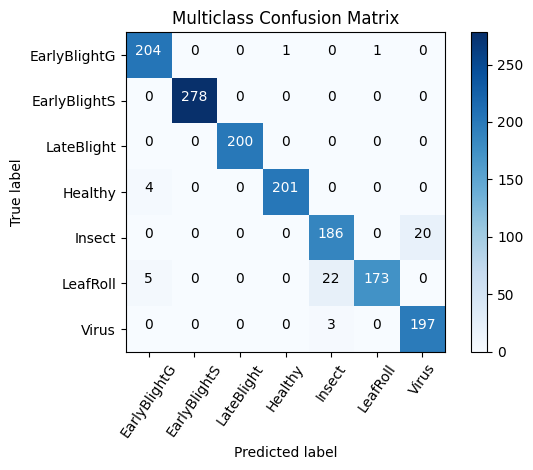

In [ ]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlightG','EarlyBlightS', 'LateBlight', 'Healthy', 'Insect','LeafRoll', 'Virus']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

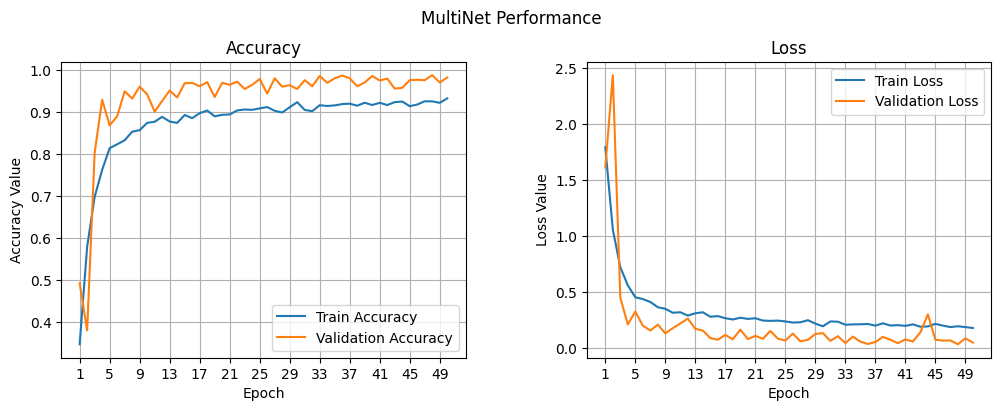

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight General','EarlyBlight Serious', 'LateBlight', 'Healthy', 'Insect','LeafRoll', 'Virus']
print(classification_report(y_test, Y_pred, target_names=target_names))

47/47 [==============================] - 5s 118ms/step
Classification Report
                     precision    recall  f1-score   support

EarlyBlight General       0.96      0.99      0.97       206
EarlyBlight Serious       1.00      1.00      1.00       278
         LateBlight       1.00      1.00      1.00       200
            Healthy       1.00      0.98      0.99       205
             Insect       0.88      0.90      0.89       206
           LeafRoll       0.99      0.86      0.93       200
              Virus       0.91      0.98      0.94       200

           accuracy                           0.96      1495
          macro avg       0.96      0.96      0.96      1495
       weighted avg       0.96      0.96      0.96      1495



In [ ]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("VGG16)")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

47/47 [==============================] - 5s 118ms/step
VGG16)
Accuracy: 0.9625418060200669
F1 Score: 0.9626496287600507
precision: 0.9643880525264974
recall: 0.9625418060200669
MSE: 0.20668896321070235
MAE: 0.07558528428093646


In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

47/47 [==============================] - 5s 119ms/step


In [ ]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=6)
auc=metrics.auc(fpr, tpr)
auc


0.37915057915057915

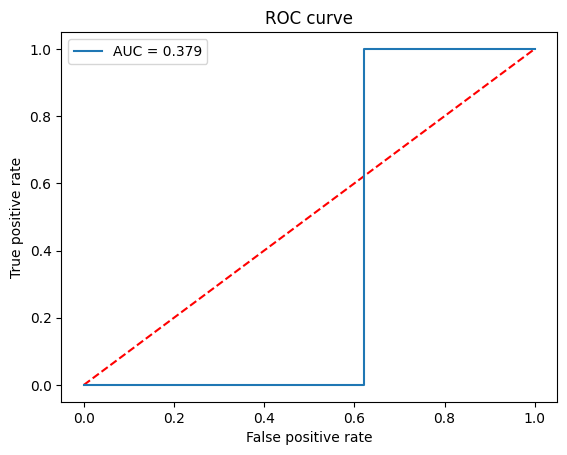

In [ ]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()
